In [1]:
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

In [2]:
# Load data
result_dir = Path('result_files')

lowly_cited_time_span = np.load(result_dir / 'lowly_cited_time_span.npy')
highly_cited_time_span = np.load(result_dir / 'highly_cited_time_span.npy')
time_span_most_cited_paper = np.load(result_dir / 'time_span_most_cited_paper.npy')



### Plot figures

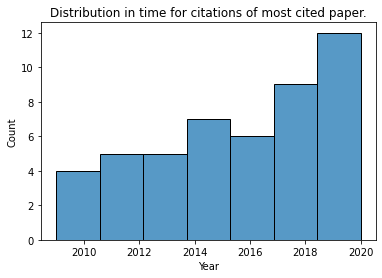

In [3]:
sns.histplot(time_span_most_cited_paper)
plt.xlabel('Year')
plt.title('Distribution in time for citations of most cited paper.')

plt.show()

Max time span: 0


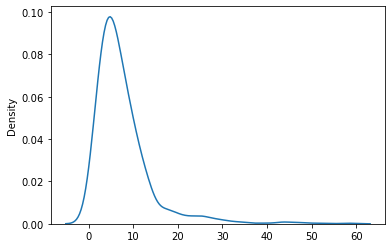

In [4]:
sns.kdeplot(highly_cited_time_span)
print(f"Max time span: {np.min(highly_cited_time_span)}")


plt.show()

<AxesSubplot:ylabel='Count'>

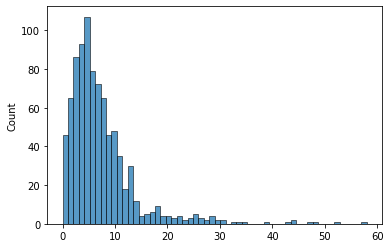

In [5]:
sns.histplot(highly_cited_time_span)

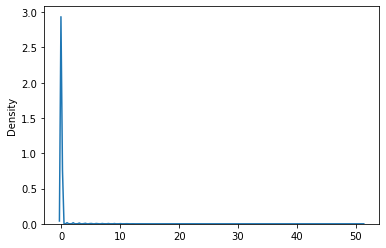

In [6]:
sns.kdeplot(lowly_cited_time_span)
plt.show()

<AxesSubplot:ylabel='Count'>

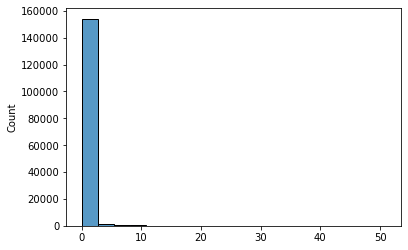

In [7]:
sns.histplot(lowly_cited_time_span)


### Graphs

In [8]:
# graph_adjlist = "/commons/dsls/dsph/2022/graph_data/adjlist_subset_data_3.csv"

# adjlist = pd.read_csv(graph_adjlist, sep=' ', header=None)
# adjlist = adjlist.astype('str')
# adjlist

In [9]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, DateType

import pyspark.sql.functions as F
import pyspark.sql.types as T

SCHEMA = StructType() \
    .add('pmid', StringType()) \
    .add('language', StringType()) \
    .add('author', StringType()) \
    .add('title', StringType()) \
    .add('co_authors', ArrayType(StringType())) \
    .add('journal', StringType()) \
    .add('key_words', ArrayType(StringType())) \
    .add('doi', StringType()) \
    .add('pmc', StringType()) \
    .add('publish_date', DateType()) \
    .add('ref_ids', ArrayType(StringType())) \
    .add("ref_authors", ArrayType(ArrayType(StringType()))) \
    .add('ref_titles', ArrayType(StringType())) \
    .add('ref_type', StringType())

def create_pyspark_df(file_path: str):
    """
    Create a pyspark dataframe from multiple json files.

    :parameters
    -----------
    file_path - str
        Directory containg json files used to create dataframe
    
    :returns
    --------
    df - pyspark DataFrame
        A pyspark dataframe
    sc - SparkContext
    spark - SparkSession
    """
    conf = pyspark.SparkConf().setAll([('spark.executor.memory', '128g'),
                                ('spark.master', 'local[16]'),
                                ('spark.driver.memory', '128g')])
    sc = SparkContext(conf=conf)
    sc.getConf().getAll()
    spark = SparkSession(sc)
    df = spark.read.option("multiline","true").schema(SCHEMA) \
        .json(file_path)
        
    return df, sc, spark


In [10]:
# json_dir = "/commons/dsls/dsph/2022/final_parsed_articles/"
# json_files = json_dir + "*.json"

# spark_df, sc, spark = create_pyspark_df(json_files)
# spark_df.show()

In [11]:
def get_data_all_articles(spark_df, adjlist_random_pd, sc):
    """
    Get the data for all the PMIDs from the pyspark dataframe this includes
    the orignal PMID that were acquired by taking the random sample of the entire dataframe
    and the PMIDs that were referenced to (available in column 'ref_ids').

    :parameters
    -----------
    spark_df - spark DataFrame
        Data frame containing info about parsed articles
    adjlist_random_pd - pd.DataFrame
        Adjacency list of the random sampled data frame
    sc - SparkContext

    :returns
    --------
    aritcles_interest_pd - pd.DataFrame
        The data of all the PMID from the random sampled df.
    """
    all_articles = []
    for i in range(len(adjlist_random_pd.columns)):
        articles = adjlist_random_pd[adjlist_random_pd.iloc[:, i].notnull()].iloc[:, i]
        all_articles.extend(articles.values)

    article_ids_broadcast = sc.broadcast(all_articles)
    articles_of_interest = spark_df.filter(F.col('pmid').isin(article_ids_broadcast.value))
    articles_interest_pd = articles_of_interest.toPandas()
    articles_interest_pd.drop_duplicates(subset=["pmid"], keep='last', inplace=True)

    return articles_interest_pd


In [12]:
# articles_interest_pd = get_data_all_articles(spark_df, adjlist, sc)
# articles_interest_pd

In [13]:
# all_articles = []
# for i in range(len(adjlist.columns)):
#     # articles = adjlist[adjlist.iloc[:, i].notnull()].iloc[:, i]
#     articles = adjlist[adjlist.iloc[:, i] != 'nan'].iloc[:, i]
#     all_articles.extend(articles.values)
# len(all_articles)

In [14]:
# np.unique(all_articles).shape

In [15]:
# article_ids_broadcast = sc.broadcast(all_articles)
# articles_of_interest = spark_df.filter(F.col('pmid').isin(article_ids_broadcast.value))

In [16]:
# articles_of_interest.show()

In [17]:
# articles_interest_pd = articles_of_interest.toPandas()
# articles_interest_pd.drop_duplicates(subset=["pmid"], keep='last', inplace=True)
# articles_interest_pd

In [18]:
# node_attributes = articles_interest_pd.set_index('pmid').to_dict('index')

In [19]:
# node_attributes

In [39]:
import pickle
subset_graph = "/commons/dsls/dsph/2022/graph_data/citation_subgraph_3.pkl"
with open(subset_graph, 'rb') as fh:
    graph = pickle.load(fh)

len(list(graph.nodes()))

162563

In [40]:
attr_names = list(graph.nodes['13471977'].keys())
attr_names

['language',
 'author',
 'title',
 'co_authors',
 'journal',
 'key_words',
 'doi',
 'pmc',
 'publish_date',
 'ref_ids',
 'ref_authors',
 'ref_titles',
 'ref_type']

In [41]:
node_attrs = {pmid:{} for pmid in graph.nodes()}

for node in graph.nodes():
    for name in attr_names:
        node_attrs[node][name] = graph.nodes[node][name]

node_attrs

{'13471977': {'language': 'eng',
  'author': 'FLETCHER, E.',
  'title': 'Paroxysmal auricular tachycardia with auriculoventricular block.',
  'co_authors': ['BRENNAN, C.F.'],
  'journal': 'British medical journal',
  'key_words': ['HEART BLOCK', 'TACHYCARDIA, PAROXYSMAL/complications'],
  'doi': '10.1136/bmj.2.5048.792',
  'pmc': 'PMC1962552',
  'publish_date': datetime.date(1957, 10, 5),
  'ref_ids': ['14844353'],
  'ref_authors': [['']],
  'ref_titles': [],
  'ref_type': 'pmid'},
 '14844353': {'language': 'eng',
  'author': 'LOWN, B.',
  'title': 'Interrelation between potassium metabolism and digitalis toxicity in heart failure.',
  'co_authors': ['SALZBERG, H.', 'ENSELBERG, C.D.', 'WESTON, R.E.'],
  'journal': 'Proceedings of the Society for Experimental Biology and Medicine. Society for Experimental Biology and Medicine (New York, N.Y.)',
  'key_words': ['DIGITALIS AND PREPARATIONS',
   'HEART, EFFECT OF DRUGS ON',
   'POTASSIUM'],
  'doi': '10.3181/00379727-76-18636',
  'pmc': ''

In [43]:
len(node_attrs)

162563

In [44]:
graph.nodes['31210720']

{'language': 'eng',
 'author': 'Dunkley, K.',
 'title': 'Cleaner personality and client identity have joint consequences on cleaning interaction dynamics.',
 'co_authors': ['Ioannou, C.C.',
  'Whittey, K.E.',
  'Cable, J.',
  'Perkins, S.E.'],
 'journal': 'Behavioral ecology : official journal of the International Society for Behavioral Ecology',
 'key_words': ['cleaner fish',
  'coral reefs',
  'mutualism',
  'personality',
  'repeatability',
  'trade-offs'],
 'doi': '10.1093/beheco/arz007',
 'pmc': 'PMC6562305',
 'publish_date': datetime.date(2019, 6, 19),
 'ref_ids': ['12138617',
  '12396217',
  '12396482',
  '12573075',
  '14667394',
  '17164196',
  '17184358',
  '17437562',
  '18481092',
  '18501468',
  '19185386',
  '21091603',
  '21367482',
  '21731670',
  '21733872',
  '22218311',
  '22239107',
  '22727728',
  '23425516',
  '24552098',
  '24671255',
  '24707058',
  '25498413',
  '27087921',
  '27652342',
  '27671145',
  '28307435',
  '29187607',
  '29247694',
  '29292533',
  '2

In [46]:
node_attrs['31210720']

{'language': 'eng',
 'author': 'Dunkley, K.',
 'title': 'Cleaner personality and client identity have joint consequences on cleaning interaction dynamics.',
 'co_authors': ['Ioannou, C.C.',
  'Whittey, K.E.',
  'Cable, J.',
  'Perkins, S.E.'],
 'journal': 'Behavioral ecology : official journal of the International Society for Behavioral Ecology',
 'key_words': ['cleaner fish',
  'coral reefs',
  'mutualism',
  'personality',
  'repeatability',
  'trade-offs'],
 'doi': '10.1093/beheco/arz007',
 'pmc': 'PMC6562305',
 'publish_date': datetime.date(2019, 6, 19),
 'ref_ids': ['12138617',
  '12396217',
  '12396482',
  '12573075',
  '14667394',
  '17164196',
  '17184358',
  '17437562',
  '18481092',
  '18501468',
  '19185386',
  '21091603',
  '21367482',
  '21731670',
  '21733872',
  '22218311',
  '22239107',
  '22727728',
  '23425516',
  '24552098',
  '24671255',
  '24707058',
  '25498413',
  '27087921',
  '27652342',
  '27671145',
  '28307435',
  '29187607',
  '29247694',
  '29292533',
  '2

In [47]:
# import pickle
out_file = "/commons/dsls/dsph/2022/graph_data/attributes_subgraph_3.pkl"
with open(out_file, 'wb') as file_handler:
    pickle.dump(node_attrs, file_handler)


In [48]:
# Load data:
import pickle
small_graph_file = "/commons/dsls/dsph/2022/graph_data/small_adjlist_subset_data_3.csv"
attributes_3_file = "/commons/dsls/dsph/2022/graph_data/attributes_subgraph_3.pkl"

with open(attributes_3_file, 'rb') as fh:
    attributes_3 = pickle.load(fh)

len(attributes_3)

small_graph = nx.read_adjlist(small_graph_file, create_using=nx.DiGraph)
nx.set_node_attributes(small_graph, attributes_3)

In [49]:
attributes_3['31210720']

{'language': 'eng',
 'author': 'Dunkley, K.',
 'title': 'Cleaner personality and client identity have joint consequences on cleaning interaction dynamics.',
 'co_authors': ['Ioannou, C.C.',
  'Whittey, K.E.',
  'Cable, J.',
  'Perkins, S.E.'],
 'journal': 'Behavioral ecology : official journal of the International Society for Behavioral Ecology',
 'key_words': ['cleaner fish',
  'coral reefs',
  'mutualism',
  'personality',
  'repeatability',
  'trade-offs'],
 'doi': '10.1093/beheco/arz007',
 'pmc': 'PMC6562305',
 'publish_date': datetime.date(2019, 6, 19),
 'ref_ids': ['12138617',
  '12396217',
  '12396482',
  '12573075',
  '14667394',
  '17164196',
  '17184358',
  '17437562',
  '18481092',
  '18501468',
  '19185386',
  '21091603',
  '21367482',
  '21731670',
  '21733872',
  '22218311',
  '22239107',
  '22727728',
  '23425516',
  '24552098',
  '24671255',
  '24707058',
  '25498413',
  '27087921',
  '27652342',
  '27671145',
  '28307435',
  '29187607',
  '29247694',
  '29292533',
  '2

In [50]:
len(list(small_graph.nodes()))

827

In [51]:
len(nx.get_node_attributes(small_graph, 'author'))

827

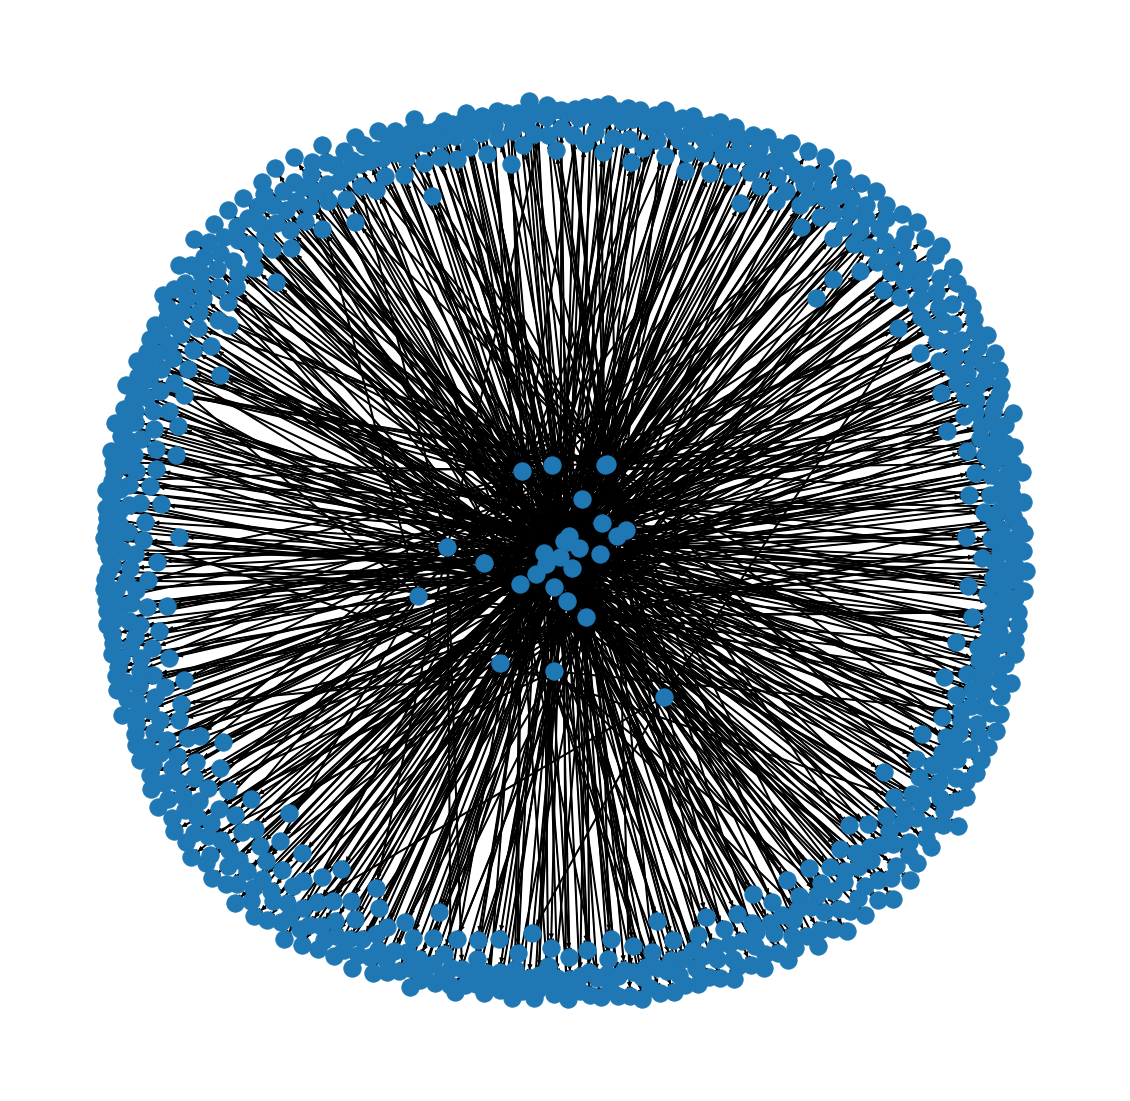

In [52]:
fig = plt.figure(figsize=(20, 20))

labels = {i:i for i in small_graph.nodes}
pos = nx.spring_layout(small_graph)


node_sizes = [20 for i in range(len(small_graph))]
M = small_graph.number_of_edges()
edge_colors = range(2, M + 2)

# nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nodes = nx.draw_networkx_nodes(small_graph, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    small_graph,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    width=2
)
nx.draw(small_graph, pos,
    arrows=True)
# nx.draw(small_graph, with_labels=False, font_weight='bold')
plt.show()


### Draw a graph that depicts if articles have key words in common

In [53]:
edge_widths, edge_colors = [], []
edge_alphas = []
for node1, node2 in list(small_graph.edges):
    attr_node1 = small_graph.nodes[node1]['key_words']
    attr_node2 = small_graph.nodes[node2]['key_words']
    edge_width, edge_color = 0.5, 'black'
    alpha = 0.3
    if attr_node1 and attr_node2:
        intersect = set(attr_node1) & set(attr_node2)
        if intersect:
            # print(f"Node1: {node1}, node2: {node2}")
            edge_width = 2
            edge_color = 'red'
            alpha = 0.8

    edge_widths.append(edge_width)
    edge_colors.append(edge_color)
    edge_alphas.append(alpha)


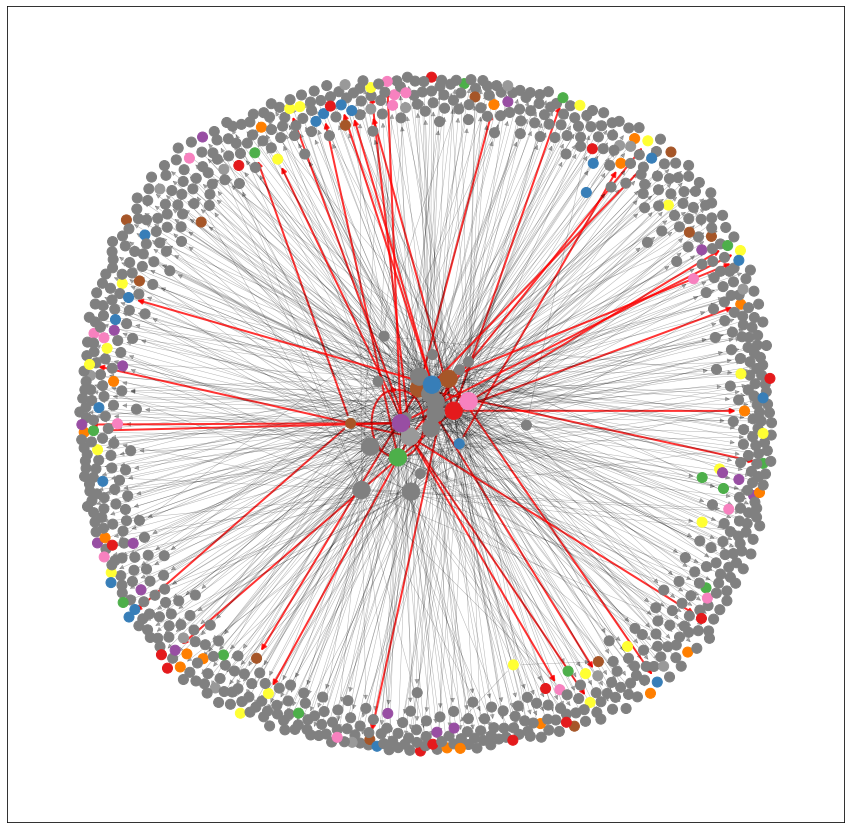

In [54]:
from itertools import count
# Try to set articles with no key words to color gray

fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(small_graph)

# labels = {i:"" for i in small_graph.nodes}
labels = {}

node_sizes = []

for node, out_degr in list(small_graph.out_degree):
        if out_degr > 20:
            labels[node] = node
            node_sizes.append(300)
        else:
            labels[node] = ""
            node_sizes.append(100)


key_words_data = {node:(key_words[0] if key_words else "None") for node, key_words in nx.get_node_attributes(small_graph,'key_words').items()}
# key_words_data

groups = set(key_words_data.values())
mapping = {}
set_1 = cm.get_cmap('Set1', len(groups))

for group, color in zip(groups, set_1.colors):
    mapping[group] = color
    if group == 'None':
        mapping[group] = np.array([.5, .5, .5, 1.0])

nodes = small_graph.nodes()
colors = [mapping[small_graph.nodes[n]['key_words'][0]] if small_graph.nodes[n]['key_words'] else mapping['None'] for n in nodes]


ec = nx.draw_networkx_edges(small_graph, pos, alpha=edge_alphas, edge_color=edge_colors, width=edge_widths)
nc = nx.draw_networkx_nodes(small_graph, pos, nodelist=nodes, 
        node_color=colors, node_size=node_sizes)# cmap=plt.cm.jet

# nx.draw_networkx_labels(small_graph, pos, labels=labels)

# plt.legend() # how to add legend: https://stackoverflow.com/questions/60706947/how-to-add-a-legend-to-networkx-graph-based-on-node-colour
plt.show()


### Draw a graph that depicts if nodes have authors in common

In [55]:
author_co_authors_flat = {}

for pmid, author in nx.get_node_attributes(small_graph, 'author').items():
    co_authors = small_graph.nodes[pmid]['co_authors']
    if author not in author_co_authors_flat:
        author_co_authors_flat[author] = co_authors
        author_co_authors_flat[author].insert(0, author)
    else:
        author_co_authors_flat[author].extend(co_authors)
        # author_co_authors_flat[author].insert(0, author)
author_co_authors_flat


{'FLETCHER, E.': ['FLETCHER, E.', 'BRENNAN, C.F.'],
 'LOWN, B.': ['LOWN, B.', 'SALZBERG, H.', 'ENSELBERG, C.D.', 'WESTON, R.E.'],
 'Dunkley, K.': ['Dunkley, K.',
  'Ioannou, C.C.',
  'Whittey, K.E.',
  'Cable, J.',
  'Perkins, S.E.',
  'Cable, J.',
  'Perkins, S.E.'],
 'Rae, G.H.': ['Rae, G.H.'],
 'Grutter, A.S.': ['Grutter, A.S.', 'Bshary, R.'],
 'Bshary, R.': ['Bshary, R.'],
 'Bever, J.D.': ['Bever, J.D.'],
 'Frost, A.J.': ['Frost, A.J.',
  'Winrow-Giffen, A.',
  'Ashley, P.J.',
  'Sneddon, L.U.'],
 'Floeter, S.R.': ['Floeter, S.R.', 'Vázquez, D.P.', 'Grutter, A.S.'],
 'Réale, D.': ['Réale, D.',
  'Reader, S.M.',
  'Sol, D.',
  'McDougall, P.T.',
  'Dingemanse, N.J.'],
 'Ioannou, C.C.': ['Ioannou, C.C.', 'Payne, M.', 'Krause, J.', 'Dall, S.R.'],
 'Biro, P.A.': ['Biro, P.A.', 'Stamps, J.A.'],
 'Bolker, B.M.': ['Bolker, B.M.',
  'Brooks, M.E.',
  'Clark, C.J.',
  'Geange, S.W.',
  'Poulsen, J.R.',
  'Stevens, M.H.',
  'White, J.S.'],
 'Webster, M.M.': ['Webster, M.M.', 'Ward, A.J.'],
 

In [57]:
edge_widths, edge_colors = [], []
edge_alphas = []
for node1, node2 in list(small_graph.edges):
    # print(node1)
    author_node1 = small_graph.nodes[node1]['author']
    co_authors_node1 = small_graph.nodes[node1]['co_authors']

    author_node2 = small_graph.nodes[node2]['author']
    co_authors_node2 = small_graph.nodes[node2]['co_authors']
    all_authors = [author_node2] + co_authors_node2
    # attr_node1 = co_authors_node1.insert(0, author_node1)
    # attr_node2 = co_authors_node2.insert(0, author_node2)
    # print(f"Authors first node: {co_authors_node1}")
    # print(f"Authors second node: {co_authors_node2}\n")
    edge_width, edge_color = 0.5, 'black'
    alpha = 0.3
    if all_authors:
        intersect = set(author_co_authors_flat[author_node1]) & set(all_authors)
        if intersect:
            print(f"\nNode1: {node1}, node2: {node2}")
            print(intersect)
            edge_width = 2
            edge_color = 'red'
            alpha = 0.8

    edge_widths.append(edge_width)
    edge_colors.append(edge_color)
    edge_alphas.append(alpha)



Node1: 31210720, node2: 18481092
{'Ioannou, C.C.'}

Node1: 31210720, node2: 27652342
{'Ioannou, C.C.'}

Node1: 31210720, node2: 27671145
{'Ioannou, C.C.'}

Node1: 31210720, node2: 29247694
{'Dunkley, K.', 'Cable, J.', 'Perkins, S.E.'}

Node1: 31210720, node2: 29899075
{'Ioannou, C.C.'}

Node1: 24611041, node2: 20850965
{'Goodson, J.L.', 'Schrock, S.E.', 'Kingsbury, M.A.', 'Kelly, A.M.', 'Thompson, R.R.', 'Kabelik, D.'}

Node1: 24611041, node2: 19679811
{'Goodson, J.L.', 'Schrock, S.E.', 'Kabelik, D.', 'Kingsbury, M.A.'}

Node1: 24611041, node2: 16643915
{'Goodson, J.L.'}

Node1: 24611041, node2: 23173212
{'Goodson, J.L.'}

Node1: 24611041, node2: 22269661
{'Goodson, J.L.', 'Kingsbury, M.A.', 'Kelly, A.M.'}

Node1: 24611041, node2: 17071744
{'Goodson, J.L.'}

Node1: 24611041, node2: 15174940
{'Thompson, R.R.'}

Node1: 24611041, node2: 19341739
{'Goodson, J.L.', 'Kabelik, D.', 'Kingsbury, M.A.'}

Node1: 24611041, node2: 19439662
{'Goodson, J.L.', 'Kabelik, D.', 'Kelly, A.M.'}

Node1: 24

In [56]:
small_graph.nodes['31210720']

{'language': 'eng',
 'author': 'Dunkley, K.',
 'title': 'Cleaner personality and client identity have joint consequences on cleaning interaction dynamics.',
 'co_authors': ['Dunkley, K.',
  'Ioannou, C.C.',
  'Whittey, K.E.',
  'Cable, J.',
  'Perkins, S.E.',
  'Cable, J.',
  'Perkins, S.E.'],
 'journal': 'Behavioral ecology : official journal of the International Society for Behavioral Ecology',
 'key_words': ['cleaner fish',
  'coral reefs',
  'mutualism',
  'personality',
  'repeatability',
  'trade-offs'],
 'doi': '10.1093/beheco/arz007',
 'pmc': 'PMC6562305',
 'publish_date': datetime.date(2019, 6, 19),
 'ref_ids': ['12138617',
  '12396217',
  '12396482',
  '12573075',
  '14667394',
  '17164196',
  '17184358',
  '17437562',
  '18481092',
  '18501468',
  '19185386',
  '21091603',
  '21367482',
  '21731670',
  '21733872',
  '22218311',
  '22239107',
  '22727728',
  '23425516',
  '24552098',
  '24671255',
  '24707058',
  '25498413',
  '27087921',
  '27652342',
  '27671145',
  '283074

In [58]:
small_graph.nodes['18481092']


{'language': 'eng',
 'author': 'Ioannou, C.C.',
 'title': 'Ecological consequences of the bold-shy continuum: the effect of predator boldness on prey risk.',
 'co_authors': ['Ioannou, C.C.', 'Payne, M.', 'Krause, J.', 'Dall, S.R.'],
 'journal': 'Oecologia',
 'key_words': [],
 'doi': '10.1007/s00442-008-1058-2',
 'pmc': '',
 'publish_date': datetime.date(2008, 5, 16),
 'ref_ids': ['11038581',
  '28312500',
  '21236920',
  '15255104',
  '17437562',
  '18707341',
  '16701288',
  '17257098',
  '16896976',
  '12713749',
  '9790704',
  '11082229'],
 'ref_authors': [['']],
 'ref_titles': [],
 'ref_type': 'pmid'}

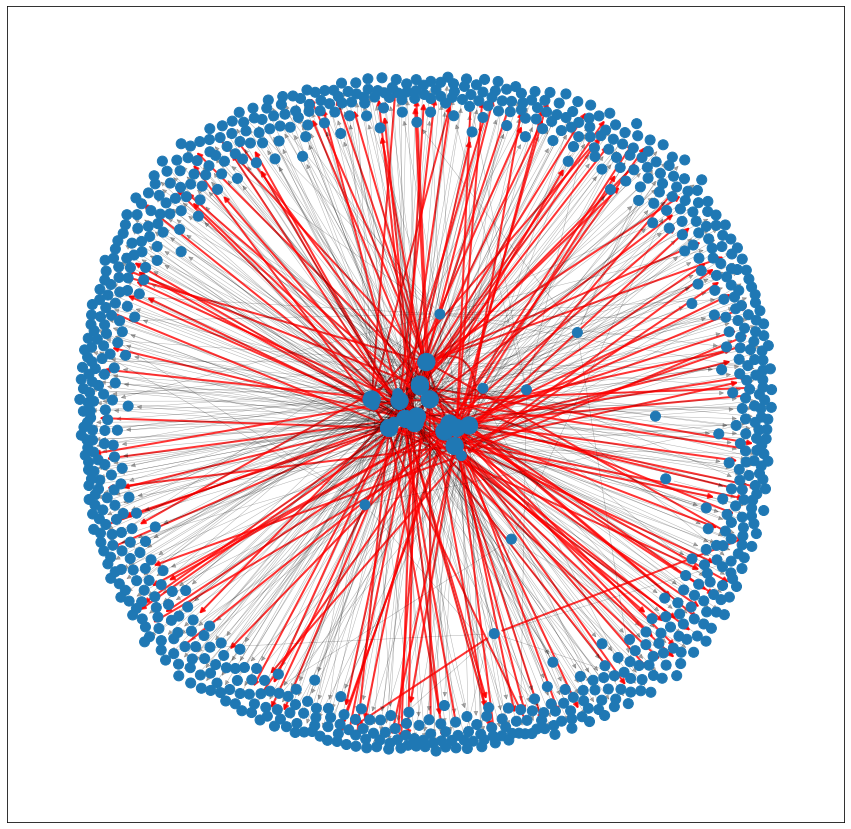

In [59]:
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(small_graph)

# labels = {i:"" for i in small_graph.nodes}
labels = {}

node_sizes = []

for node, out_degr in list(small_graph.out_degree):
        if out_degr > 20:
            labels[node] = node
            node_sizes.append(300)
        else:
            labels[node] = ""
            node_sizes.append(100)


# key_words_data = {node:(key_words[0] if key_words else "None") for node, key_words in nx.get_node_attributes(small_graph,'key_words').items()}
# # key_words_data

# groups = set(key_words_data.values())
# mapping = {}
# set_1 = cm.get_cmap('Set1', len(groups))

# for group, color in zip(groups, set_1.colors):
#     mapping[group] = color
#     if group == 'None':
#         mapping[group] = np.array([.5, .5, .5, 1.0])

nodes = small_graph.nodes()
# colors = [mapping[small_graph.nodes[n]['key_words'][0]] if small_graph.nodes[n]['key_words'] else mapping['None'] for n in nodes]


ec = nx.draw_networkx_edges(small_graph, pos, alpha=edge_alphas, edge_color=edge_colors, width=edge_widths)
nc = nx.draw_networkx_nodes(small_graph, pos, nodelist=nodes,node_size=node_sizes)# cmap=plt.cm.jet

# nx.draw_networkx_labels(small_graph, pos, labels=labels)

# plt.legend() # how to add legend: https://stackoverflow.com/questions/60706947/how-to-add-a-legend-to-networkx-graph-based-on-node-colour
plt.show()
